##### 串接 Email，寄送使用者的圖片或影片
這篇教學會延續「儲存使用者傳送的圖片或影片」範例，搭配 smtplib 和 email 標準函式庫，當收到使用者所傳送圖片或影片時，\
直接將檔案透過 Email 的方式寄出，就可以透過 Email 的附件保存檔案。

##### 本機環境串接 Email 
參考「串接 Gmail 寄送電子郵件」教學內容，先申請 Google 應用程式密碼，並閱讀「附加檔案的 email」範例程式，\
將發送 Email 的程式碼獨立成一個 sendEmail 函式，並與原本接收圖片與影片的程式碼結合。

In [ ]:
from flask import Flask, request

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

# 載入 smtplib 和 email 函式庫
import smtplib
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import json
app = Flask(__name__)

def sendEmail(txt, source, fileName, email, pwd):
    msg = MIMEMultipart()
    attach_file = MIMEApplication(source, Name=fileName)  # 附加檔案
    msg.attach(attach_file)
    msg['Subject'] = txt   # 標題
    msg['From'] = email    # 給誰 ( 通常是給自己 )
    msg['To'] = email      # 寄件者
    smtp = smtplib.SMTP('smtp.gmail.com', 587)
    smtp.ehlo()
    smtp.starttls()
    smtp.login(email, pwd) # 使用應用程式密碼登入
    status = smtp.send_message(msg)
    print(status)
    smtp.quit()

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = '你的 Access Token'
        secret = '你的 Channel Secret'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        type = json_data['events'][0]['message']['type']     # 取得 LINE 收到的訊息類型
        # 判斷如果是文字
        if type=='text':
            msg = json_data['events'][0]['message']['text']  # 取得 LINE 收到的文字訊息
            reply = msg
        # 判斷如果是圖片
        elif type == 'image':
            msgID = json_data['events'][0]['message']['id']  # 取得訊息 id
            message_content = line_bot_api.get_message_content(msgID)  # 根據訊息 ID 取得訊息內容
            # 在同樣的資料夾中建立以訊息 ID 為檔名的 .jpg 檔案
            sendEmail('LINE 傳圖片來囉！', message_content.content, f'{msgID}.jpg', '你的 Email', '你申請的應用程式密碼')
            reply = '圖片儲存完成！'                             # 設定要回傳的訊息
        # 判斷如果是影片
        elif type=='video':
            msgID = json_data['events'][0]['message']['id']
            message_content = line_bot_api.get_message_content(msgID)
            sendEmail('LINE 傳影片來囉！', message_content.content, f'{msgID}.mp4', '你的 Email', '你申請的應用程式密碼')
            reply = '影片儲存完成！'
        else:
            reply = '你傳的不是文字或圖片呦～'
        print(reply)
        line_bot_api.reply_message(tk,TextSendMessage(reply))  # 回傳訊息
    except:
        print(body)             # 如果發生錯誤，印出收到的內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
    app.run()

完成後執行程式 ( 記得先使用 ngrok 產生 webhook 網址並提交至 LINE Developer )，傳送圖片或影片到 LINE BOT，該圖片或影片就會自動轉寄到 Email。

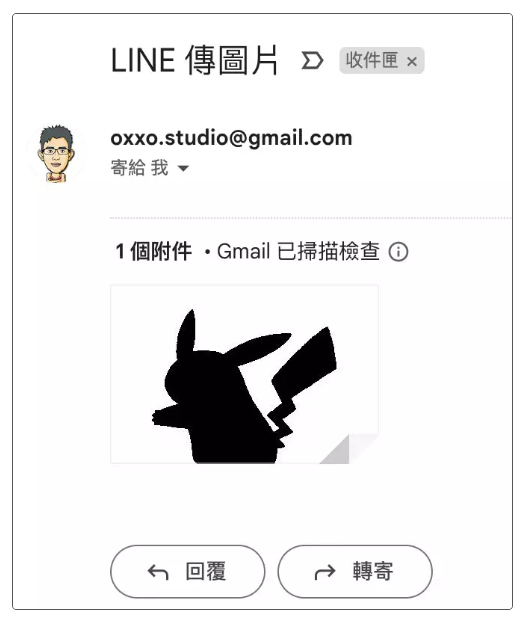

##### Colab 串接 Email 
如果要使用 Colab 作為開發環境，參考「[設定 Colab 開發環境](https://steam.oxxostudio.tw/category/python/example/line-colab.html)」，使用下方程式碼，就可以將使用者傳送的圖片或影片，轉傳到指定的 Email。

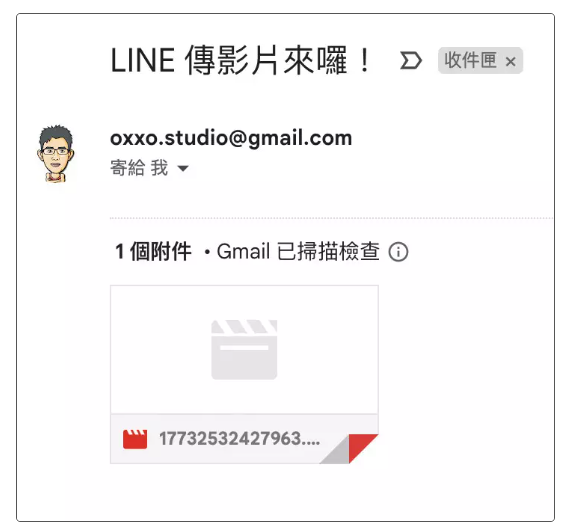

In [ ]:
from flask import Flask, request
from pyngrok import ngrok   # Colab 環境需要，本機環境不需要

# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

# 載入 smtplib 和 email 函式庫
import smtplib
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import json
app = Flask(__name__)

def sendEmail(txt, source, fileName, email, pwd):
    msg = MIMEMultipart()
    attach_file = MIMEApplication(source, Name=fileName)  # 附加檔案
    msg.attach(attach_file)
    msg['Subject'] = txt   # 標題
    msg['From'] = email    # 給誰 ( 通常是給自己 )
    msg['To'] = email      # 寄件者
    smtp = smtplib.SMTP('smtp.gmail.com', 587)
    smtp.ehlo()
    smtp.starttls()
    smtp.login(email, pwd) # 使用應用程式密碼登入
    status = smtp.send_message(msg)
    print(status)
    smtp.quit()

# Colab 環境需要下面這三行，本機環境不需要
port = "5000"
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')  # Colab 換路徑使用

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        json_data = json.loads(body)                         # json 格式化訊息內容
        access_token = '你的 Access Token'
        secret = '你的 Channel Secret'
        line_bot_api = LineBotApi(access_token)              # 確認 token 是否正確
        handler = WebhookHandler(secret)                     # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']      # 加入回傳的 headers
        handler.handle(body, signature)                      # 綁定訊息回傳的相關資訊
        tk = json_data['events'][0]['replyToken']            # 取得回傳訊息的 Token
        type = json_data['events'][0]['message']['type']     # 取得 LINE 收到的訊息類型
        # 判斷如果是文字
        if type=='text':
            msg = json_data['events'][0]['message']['text']  # 取得 LINE 收到的文字訊息
            reply = msg
        # 判斷如果是圖片
        elif type == 'image':
            msgID = json_data['events'][0]['message']['id']  # 取得訊息 id
            message_content = line_bot_api.get_message_content(msgID)  # 根據訊息 ID 取得訊息內容
            # 在同樣的資料夾中建立以訊息 ID 為檔名的 .jpg 檔案
            sendEmail('LINE 傳圖片來囉！', message_content.content, f'{msgID}.jpg', '你的 Email', '你申請的應用程式密碼')
            reply = '圖片儲存完成！'                             # 設定要回傳的訊息
        # 判斷如果是影片
        elif type=='video':
            msgID = json_data['events'][0]['message']['id']
            message_content = line_bot_api.get_message_content(msgID)
            sendEmail('LINE 傳影片來囉！', message_content.content, f'{msgID}.mp4', '你的 Email', '你申請的應用程式密碼')
            reply = '影片儲存完成！'
        else:
            reply = '你傳的不是文字或圖片呦～'
        print(reply)
        line_bot_api.reply_message(tk,TextSendMessage(reply))  # 回傳訊息
    except:
        print(body)             # 如果發生錯誤，印出收到的內容
    return 'OK'                 # 驗證 Webhook 使用，不能省略
if __name__ == "__main__":
    app.run()

##### 小結 
因為透過 OAuth2.0 串接 Google 雲端硬碟相對來說比較麻煩，且對於初學者來說有一些安全性的疑慮，所以如果真的要保留圖片或影片，\
藉由 LINE BOT 接收後再串接 Email 發送，是相當不錯的保存檔案方式。